# **Rapid object detection using a boosted cascade of simple features** (2001)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.datasets import fetch_lfw_people
from tqdm import tqdm

In [2]:
def load_data(num_faces=100):
    lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.5)
    X = lfw_people.data
    y = lfw_people.target
    names = lfw_people.target_names
    
    indices = np.random.choice(len(X), num_faces, replace=False)
    X_selected = X[indices]
    y_selected = y[indices]
    
    return X_selected, y_selected, names

In [3]:
def compute_integral_image(image):
    return cv2.integral(image)

In [4]:
def extract_features(integral_image, x, y, size=24):
    features = []
    
    for i in range(size):
        for j in range(size):
            feature_sum = integral_image[y + size, x + size] \
                        - integral_image[y + size, x] \
                        - integral_image[y, x + size] \
                        + integral_image[y, x]
            features.append(feature_sum)
    return features

In [5]:
def train_weak_classifier(features, labels, num_stages=5):
    thresholds = []  # 다단계 threshold를 저장할 리스트
    for stage in range(num_stages):
        best_threshold = None
        best_accuracy = 0
        
        possible_thresholds = np.linspace(np.min(features), np.max(features), 100)
        
        for threshold in tqdm(possible_thresholds, desc=f"Finding optimal threshold for stage {stage + 1}"):
            predictions = []
            
            for img_features, label in zip(features, labels):
                for feature in img_features:
                    predictions.append(1 if feature > threshold else 0)
            
            accuracy = np.mean(predictions == np.repeat(labels, [len(f) for f in features]))
            
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_threshold = threshold
                
        thresholds.append(best_threshold)  # 최적의 threshold를 리스트에 추가

    return thresholds

In [6]:
def cascade_detect_faces(test_image, thresholds):
    detected_faces = []
    integral_image = compute_integral_image(test_image)
    height, width = test_image.shape
    
    for y in tqdm(range(height - 24), desc="Detecting faces in cascade"):
        for x in range(width - 24):
            features = extract_features(integral_image, x, y)
            feature_sum = np.sum(features)
            passed_all = True
            
            for threshold in thresholds:
                if feature_sum <= threshold:
                    passed_all = False
                    break
            
            if passed_all:
                detected_faces.append((y, x))
                
    return detected_faces

In [7]:
def non_maximum_suppression(detected_faces, threshold=0.5):
    if len(detected_faces) == 0:
        return []

    boxes = np.array(detected_faces)
    x1 = boxes[:, 1]
    y1 = boxes[:, 0]
    x2 = boxes[:, 1] + 24
    y2 = boxes[:, 0] + 24

    scores = (x2 - x1) * (y2 - y1)
    indices = np.argsort(scores)

    selected_boxes = []

    for i in tqdm(range(len(boxes)), desc="NMS 진행 중"):
        current_index = indices[i]
        suppress = False
        for selected_index in selected_boxes:
            xA = max(x1[current_index], x1[selected_index])
            yA = max(y1[current_index], y1[selected_index])
            xB = min(x2[current_index], x2[selected_index])
            yB = min(y2[current_index], y2[selected_index])

            interArea = max(0, xB - xA) * max(0, yB - yA)
            boxA_area = scores[current_index]
            boxB_area = scores[selected_index]
            iou = interArea / float(boxA_area + boxB_area - interArea)

            if iou > threshold:
                suppress = True
                break

        if not suppress:
            selected_boxes.append(current_index)

    return [(y1[i], x1[i], y2[i], x2[i]) for i in selected_boxes]

In [8]:
def merge_boxes(detected_faces):
    if len(detected_faces) == 0:
        return []

    boxes = np.array(detected_faces)
    y1 = boxes[:, 0]
    x1 = boxes[:, 1]
    y2 = boxes[:, 0] + 24
    x2 = boxes[:, 1] + 24

    # 진행 상태를 시각화하기 위해 tqdm을 사용하여 반복
    merged_y1 = np.min(y1)
    merged_x1 = np.min(x1)
    merged_y2 = np.max(y2)
    merged_x2 = np.max(x2)

    # tqdm을 이용하여 각 박스에 대해 병합 상태를 출력
    for i in tqdm(range(len(boxes)), desc="Merging boxes"):
        # 이 예제에서는 병합을 위해 특별한 로직이 없지만, 
        # 이후 로직에 맞게 추가적인 작업을 여기에 구현할 수 있습니다.
        pass

    return [(merged_y1, merged_x1, merged_y2, merged_x2)]

In [9]:
def visualize_results(test_images, detected_faces):
    # 원본 이미지 시각화
    plt.figure(figsize=(15, 6))
    for i, image in enumerate(test_images[:5]):
        plt.subplot(1, 5, i + 1)
        plt.imshow(image.reshape(62, 47), cmap='gray')
        plt.title("Original Image")
        plt.axis('off')
    plt.show()
    plt.close()

    # NMS 적용 전 시각화
    plt.figure(figsize=(15, 6))
    for i, (image, faces) in enumerate(zip(test_images[:5], detected_faces[:5])):
        plt.subplot(1, 5, i + 1)
        plt.imshow(image.reshape(62, 47), cmap='gray')
        if faces:
            for (y, x) in faces:
                plt.gca().add_patch(plt.Rectangle((x, y), 24, 24, edgecolor='blue', linewidth=2, fill=False))
        plt.title("Before NMS")
        plt.axis('off')
    plt.show()
    plt.close()

    # NMS 적용 후 결과 시각화
    plt.figure(figsize=(15, 6))
    for i, (image, faces) in enumerate(zip(test_images[:5], detected_faces[:5])):
        plt.subplot(1, 5, i + 1)
        plt.imshow(image.reshape(62, 47), cmap='gray')
        if faces:
            nms_faces = non_maximum_suppression(faces)
            for (y1, x1, y2, x2) in nms_faces:
                plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor='red', linewidth=2, fill=False))
        plt.title("After NMS")
        plt.axis('off')
    plt.show()
    plt.close()

    # 최종 결과 시각화
    plt.figure(figsize=(15, 6))
    for i, (image, faces) in enumerate(zip(test_images[:5], detected_faces[:5])):
        plt.subplot(1, 5, i + 1)
        plt.imshow(image.reshape(62, 47), cmap='gray')
        if faces:
            nms_faces = non_maximum_suppression(faces)
            merged_faces = merge_boxes(nms_faces)
            for (y1, x1, y2, x2) in merged_faces:
                plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor='green', linewidth=2, fill=False))
        plt.title("After bbox Aggregation")
        plt.axis('off')
    plt.show()
    plt.close()


Detecting faces in test images: 100%|██████████| 10/10 [00:03<00:00,  2.65it/s]


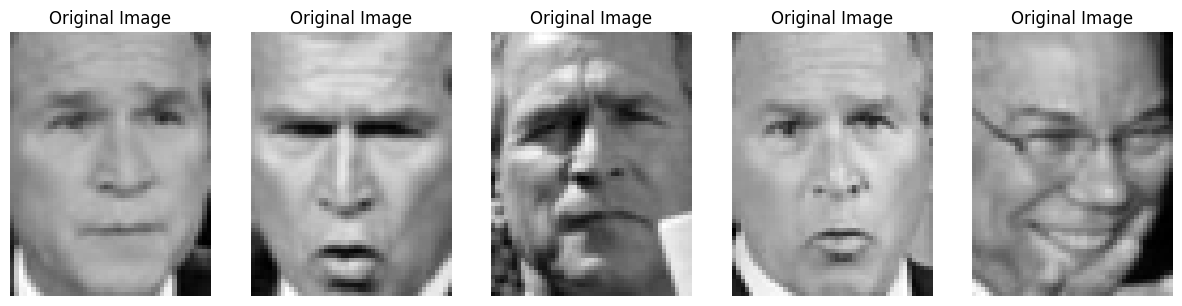

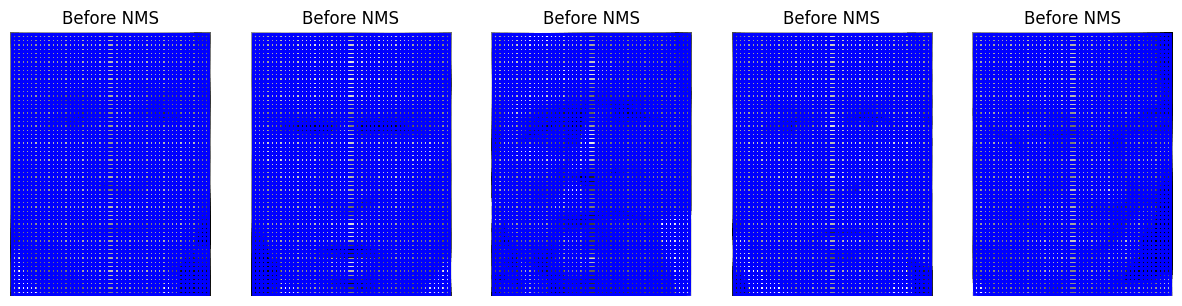

NMS 진행 중: 100%|██████████| 874/874 [00:00<00:00, 31512.26it/s]


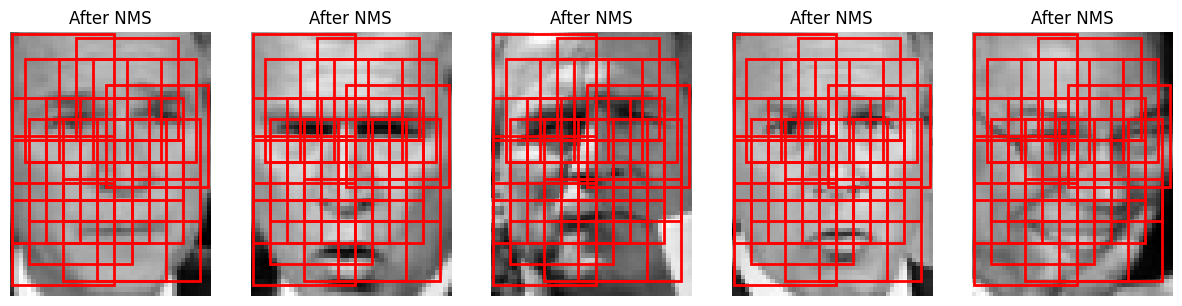

Merging boxes: 100%|██████████| 19/19 [00:00<00:00, 517479.06it/s]


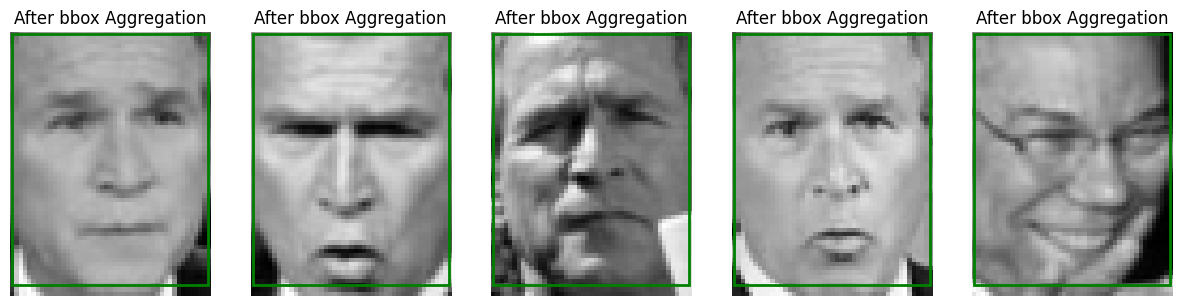

In [10]:
# 1. 메인 실행
X_selected, y_selected, names = load_data(num_faces=100)

features = []
for img in tqdm(X_selected, desc="Extracting features"):
    img_reshaped = img.reshape(62, 47)
    integral_image = compute_integral_image(img_reshaped)
    features.append(extract_features(integral_image, 0, 0))

features_flattened = [extract_features(compute_integral_image(img.reshape(62, 47)), 0, 0) for img in X_selected]

# 2. 약한 분류기 학습 및 최적의 threshold 찾기
threshold = train_weak_classifier(features_flattened, y_selected)

# 3. 테스트 이미지 준비 (100개의 이미지 중 10개 선택)
test_indices = np.random.choice(len(X_selected), 10, replace=False)
test_images = X_selected[test_indices]

# 4. 얼굴 탐지
detected_faces_list = []
for img in tqdm(test_images, desc="Detecting faces in test images"):
    img_reshaped = img.reshape(62, 47)
    detected_faces = cascade_detect_faces(img_reshaped, threshold)
    detected_faces_list.append(detected_faces)

# 5. 결과 시각화
visualize_results(test_images, detected_faces_list)